In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
import time

In [8]:
#Loading data from local folder
df=pd.read_csv("HighthroughputDFTcalculations.csv")

#columns to be encoded to numeric
col_change=['Formation energy [eV/atom]','Stability [eV/atom]',
       'Magnetic moment [mu_B]', 'Volume per atom [A^3/atom]', 'Band gap [eV]',
       'a [ang]', 'b [ang]', 'c [ang]', 'alpha [deg]', 'beta [deg]',
       'gamma [deg]', 'Vacancy energy [eV/O atom]']

for i in col_change:
    df[i]=pd.to_numeric(df[i], errors="coerce")
# The LowestDist is linked to crystallography of the materials and in the dataset, there are many features which
#might have underlying interaction with LowestDist. The question is that how the crystal structure of the material can
#influence the properties of the materials.So the LowetDsit is a our target label.  

# Since the unique values of label are low, it is possible to apply manual ordinal encoding. 
ordinal_encoding={"cubic":1, "orthorhombic":2, "rhombohedral":3,"tetragonal":4,"-":5 }
df["LowestDist"]=df["Lowest distortion"].replace(ordinal_encoding)

#col_obj contains features which are numeric and will be used for the model training. The new dataframe is called DFT.
col_obj=[col for col in df.columns if df[col].dtypes in ["float64", "int64"]]
DFT=df[col_obj]   #  new DataFrame

#Missing Values
#The feature "Magnetic moment" has large percentage missing values, and currently it is not our focus. 
DFT=DFT.drop("Magnetic moment [mu_B]", axis=1)
DFT=DFT.dropna(axis=0)

#Defining Features and Label
features=DFT.drop("LowestDist", axis=1)
labels=DFT["LowestDist"]


X_train, X_test, y_train, y_test=train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)


In [61]:
#LogisticRegression classifier
def log_reg_model():
    """ This function applies logistic regression. the preprocessing includes both StandardScaler and 
    PolynomialFeature stpes """
    
    #Hpyerparameter tunning, solver Saga works for large multiclass datasets
    #the degree of Polynomial feature is chosen after try out different values
    
    pipe_model=Pipeline(steps=[("scale",StandardScaler()),
                             ("clf",LogisticRegression(max_iter=100000, random_state=42))],
                   )
    param_grid= {
           "scale__with_mean":[True, False],
           "scale__with_std":[True, False],
           "clf__C":[0.05, 0.1,0.5],
           "clf__penalty":["l2"],
            "clf__solver":["saga"],
               }
    
    grid_reg=GridSearchCV(pipe_model, param_grid,cv=10, n_jobs=4, verbose=False, scoring="accuracy")
    
    grid_reg.fit(X_train, y_train)
    
    a1=grid_reg.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_reg.best_estimator_.get_params()["scale__with_std"]
    a3=grid_reg.best_estimator_.get_params()["clf__C"]
    a4=grid_reg.best_estimator_.get_params()["clf__penalty"]
    a5=grid_reg.best_estimator_.get_params()["clf__solver"]
    
    reg_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    LogisticRegression(C=a3,penalty=a4, solver=a5, max_iter=10000)
    )
    # The score of trained and test datasets 
    train_score=reg_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=reg_final.fit(X_test, y_test).score(X_test, y_test)

    return reg_final, train_score, test_score

# RandomForest Classifier
def randfor_model():
    """ This function applies RandomForest classifier on dataset with StandardScaler as preprocessing step
    and it returns the final model with best parameters, and the score for train and test"""
    
    
    #Hpyerparameter tunning is limited to only three important paramters of the rf classifeir 

    pipe_model=Pipeline(steps=[("scale", StandardScaler()), ("rf",RandomForestClassifier(random_state=42))]) 

    param_grid={
        "scale__with_mean":["True", "False"],
              "scale__with_std":["True", "False"],
              "rf__n_estimators":[10, 50,100],
              "rf__max_depth":[4,5,6],
              "rf__max_features":[4,5,6]
    }


    grid_rf=GridSearchCV(pipe_model,param_grid=param_grid, cv=10,n_jobs=4, verbose=False, scoring="accuracy")

    grid_rf.fit(X_train, y_train)

    a1=grid_rf.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_rf.best_estimator_.get_params()["scale__with_std"]
    a3=grid_rf.best_estimator_.get_params()["rf__n_estimators"]
    a4=grid_rf.best_estimator_.get_params()["rf__max_depth"]
    a5=grid_rf.best_estimator_.get_params()["rf__max_features"]
    
    rf_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    RandomForestClassifier(n_estimators=a3, max_depth=a4, max_features=a5)
    )
    # The score of trained and test datasets 
    train_score=rf_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=rf_final.fit(X_test, y_test).score(X_test, y_test)

    return rf_final, train_score, test_score

#KNearestNeighbor Classifier
def knn_model():
    " This function applies KNN model on the dataset, with StanddardScaling as a preprocessing step  "
    
    #Hpyerparameter tunning 

    knn=KNeighborsClassifier()
    pipe_model= Pipeline(steps=[("scale",StandardScaler()),("knn",knn)])
    param_grid={
            "scale__with_mean":["True", "False"],
              "scale__with_std":["True", "False"],
              "knn__n_neighbors":[4, 5],
              "knn__leaf_size":[2, 3],
              "knn__p":[1]}
    grid_knn=GridSearchCV(pipe_model, param_grid,cv=10, n_jobs=4, verbose=False, scoring="accuracy")
    grid_knn.fit(X_train, y_train)
    
    a1=grid_knn.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_knn.best_estimator_.get_params()["scale__with_std"]
    a3=grid_knn.best_estimator_.get_params()['knn__n_neighbors']
    a4=grid_knn.best_estimator_.get_params()['knn__leaf_size']
    a5=grid_knn.best_estimator_.get_params()['knn__p']
    
    knn_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    KNeighborsClassifier(n_neighbors=a3, leaf_size=a4, p=a5)
    )
    # The score of trained and test datasets 
    train_score=knn_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=knn_final.fit(X_test, y_test).score(X_test, y_test)

    return knn_final, train_score, test_score
print(knn_model()[0])

# AdaBoost Classifeir 
def ada_boost_model():
    """ AdaBoost Classifier """
    #Hpyerparameter tunning 

    pipe_model=Pipeline(steps=[("scale",StandardScaler()),("ada",AdaBoostClassifier(random_state=42, algorithm="SAMME"))])
                               
    param_grid={
        "scale__with_mean":["True", "False"],
              "scale__with_std":["True", "False"],
               "ada__n_estimators":[5, 10, 50],
               "ada__learning_rate":[0.01, 0.1, 1]}

    grid_ada=GridSearchCV(pipe_model, param_grid, cv=10,n_jobs=4, scoring="accuracy")

    grid_ada.fit(X_train, y_train)
    
    a1=grid_ada.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_ada.best_estimator_.get_params()["scale__with_std"]
    a3=grid_ada.best_estimator_.get_params()['ada__n_estimators']
    a4=grid_ada.best_estimator_.get_params()['ada__learning_rate']
    
    ada_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    AdaBoostClassifier(n_estimators=a3,learning_rate=a4)
    )
    # The score of trained and test datasets from AdaBoost Classifier
    train_score=ada_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=ada_final.fit(X_test, y_test).score(X_test, y_test)

    return ada_final, train_score, test_score
print(ada_boost_model()[0]) 


def get_models():
    """ The name of all models defined as a function"""
    models = dict()
    models["LogReg"]=log_reg_model()
    models["RandFor"]=randfor_model()
    models["knn"] = knn_model()
    models["AdaBoost"]=ada_boost_model()

    return models



def score(name, model):
    """ the classification report """
    y_pred=model[0].predict(X_test)
    macro_ave=classification_report(y_test, y_pred, output_dict=True).get("macro avg")
    weighted_ave= classification_report(y_test, y_pred, output_dict=True).get("weighted avg")
    
    score_list1=pd.DataFrame(
        {"parameters_":macro_ave.keys(),"macro_ave_"+name:macro_ave.values(),"weighted_ave_"+name:weighted_ave.values()
        })   
    
    score_series = pd.Series({"score_train_"+name:model[1], "score test_"+name: model[2]})
    
    score_list=pd.concat([score_list1, score_series.to_frame().T],ignore_index=True, axis=0 )
    return score_list  
    
    
for name, model in get_models().items():
    print(score(name, model))


Pipeline(steps=[('standardscaler',
                 StandardScaler(with_mean='True', with_std='True')),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=2, n_neighbors=4, p=1))])
Pipeline(steps=[('standardscaler',
                 StandardScaler(with_mean='True', with_std='True')),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=1, n_estimators=10))])
  parameters_  macro_ave_LogReg  weighted_ave_LogReg  score_train_LogReg  \
0   precision          0.996798             0.991969                 NaN   
1      recall          0.909091             0.991864                 NaN   
2    f1-score          0.942833             0.990987                 NaN   
3     support       1475.000000          1475.000000                 NaN   
4         NaN               NaN                  NaN            0.992149   

   score test_LogReg  
0                NaN  
1                NaN  
2                NaN  
3               

the train score is  0.9270136667635941
the test score is  0.8949152542372881


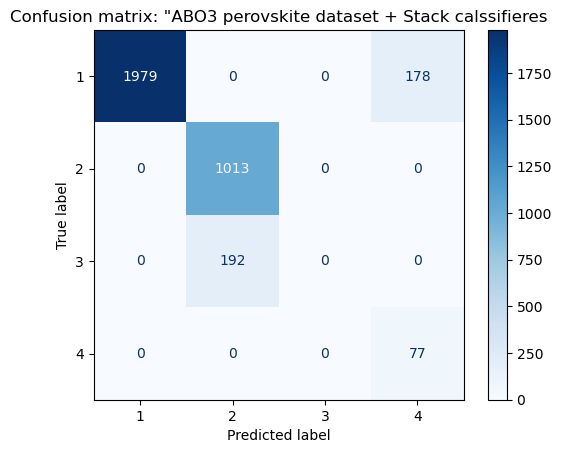

              precision    recall  f1-score   support

           1       1.00      0.92      0.96       925
           2       0.84      1.00      0.91       434
           3       0.00      0.00      0.00        83
           4       0.32      1.00      0.49        33

    accuracy                           0.89      1475
   macro avg       0.54      0.73      0.59      1475
weighted avg       0.88      0.89      0.88      1475

Duration: 0:00:13.945200


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
base_learner=[
    ("base_lr", log_reg_model()[0]),
    ("base_rf", randfor_model()[0]), 
    ("base_knn", knn_model()[0])
    ]
             
clf=StackingClassifier(estimators=base_learner, final_estimator=ada_boost_model()[0], cv=10, n_jobs=4)
start_time=datetime.now()

start_time=datetime.now()

print("the train score is ",clf.fit(X_train, y_train).score(X_train, y_train))
print("the test score is ",clf.fit(X_train, y_train).score(X_test, y_test))

from sklearn.metrics import ConfusionMatrixDisplay

clf_display=ConfusionMatrixDisplay.from_estimator(clf,X_train, y_train,
                                                  labels=clf.classes_,cmap=plt.cm.Blues,colorbar=True)
clf_display.ax_.set_title('Confusion matrix: "ABO3 perovskite dataset + Stack calssifieres')
plt.show()

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

end_time=datetime.now()

print('Duration: {}'.format(end_time - start_time))

In [ ]:

def score(name, model):
    """ the classification report """
    y_pred=model[0].predict(X_test)
    macro_ave=classification_report(y_test, y_pred, output_dict=True).get("macro avg")
    weighted_ave= classification_report(y_test, y_pred, output_dict=True).get("weighted avg")
    score_list=pd.DataFrame(
        {"parameters_"+name:macro_ave.keys(),"macro_ave_"+name:macro_ave.values(),"weighted_ave_"+name:weighted_ave.values()
        , "score_train_"+name:model[1], "score test_"+name: model[2]},
    
    )   
   
    return score_list  

In [ ]:
def score(name, model):
    """ the classification report """
    y_pred=model[0].predict(X_test)
    macro_ave=classification_report(y_test, y_pred, output_dict=True).get("macro avg")
    weighted_ave= classification_report(y_test, y_pred, output_dict=True).get("weighted avg")
    score_list=pd.DataFrame(
        {"macro_ave_"+name:macro_ave.values(),"weighted_ave_"+name:weighted_ave.values()},
        index=macro_ave.keys()
    )   
   
    return score_list  
    
    
for name, model in get_models().items():
    print(score(name, model))


In [ ]:
def log_reg_model():
    """ This function applies logistic regression. the preprocessing includes both StandardScaler and 
    PolynomialFeature stpes """
    
    #Hpyerparameter tunning, solver Saga works for large multiclass datasets
    #the degree of Polynomial feature is chosen after try out different values
    
    pipe_model=Pipeline(steps=[("scale",StandardScaler()),
                          ("poly",PolynomialFeatures()),
                          ("clf",LogisticRegression(max_iter=100000, random_state=42))],
                   )
    param_grid= {
           "scale__with_mean":[True, False],
           "scale__with_std":[True, False],
           "poly__degree":[2],
           "clf__C":[0.05, 0.1,0.5],
           "clf__penalty":["l2"],
            "clf__solver":["saga"],
               }
    
    grid_reg=GridSearchCV(pipe_model, param_grid,cv=10, n_jobs=4, verbose=False, scoring="accuracy")
    
    grid_reg.fit(X_train, y_train)
    
    a1=grid_reg.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_reg.best_estimator_.get_params()["scale__with_std"]
    a3=grid_reg.best_estimator_.get_params()["clf__C"]
    a4=grid_reg.best_estimator_.get_params()["clf__penalty"]
    a5=grid_reg.best_estimator_.get_params()["clf__solver"]
    a6=grid_reg.best_estimator_.get_params()["poly__degree"]
    
    #extra check point
    print(grid_reg.best_params_)
    
    reg_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    PolynomialFeatures(degree=a6),LogisticRegression(C=a3,penalty=a4, solver=a5, max_iter=10000)
    )
    # The score of trained and test datasets 
    train_score=reg_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=reg_final.fit(X_test, y_test).score(X_test, y_test)

    return reg_final, train_score, test_score

start_time=datetime.now()
log_reg_store=log_reg_model()[0]
stop_time=datetime.now()
print('Duration: {}'.format(stop_time - start_time))


In [ ]:
# this class was not tried 
class best_score:
    def __init__(self,model_name):
        self.model = model_name
        self.train_score = []
        self.test_score = []
        self.f1_scores=[]
    def fit(self, X,y):
        self.fit(X_test, y_test)
    def add_f1(self,x):
        self.f1_scores.append(x)
        
    def add_train_score(self, model_name):
        self.train_score.append()
    def add_test_score(self, model_name):
        self.test_score.append()

    def summary(self):
        f1_mean = np.mean(self.f1_scores)
        f1_std = np.std(self.f1_scores)
        return {self.nmodel : {
            'f1_mean' : f1_mean,
            'f1_std' : f1_std,
            "train_score":self.train_score,
            "test_score":self.test_score
        }}
    

def         
    
# reserved for future ********************


def knn_model():
    "   "
    knn=KNeighborsClassifier()
    pipe_model= Pipeline(steps=[("scale",StandardScaler()),("knn",knn)])
    param_grid={
            "scale__with_mean":["True", "False"],
              "scale__with_std":["True", "False"],
              "knn__n_neighbors":[4, 5],
              "knn__leaf_size":[2, 3],
              "knn__p":[1]}
    grid_knn=GridSearchCV(pipe_model, param_grid,cv=10, n_jobs=4, verbose=False, scoring="accuracy")
    grid_knn.fit(X_train, y_train)
    
    a1=grid_knn.best_estimator_.get_params()["scale__with_mean"]
    a2=grid_knn.best_estimator_.get_params()["scale__with_std"]
    a3=grid_knn.best_estimator_.get_params()['knn__n_neighbors']
    a4=grid_knn.best_estimator_.get_params()['knn__leaf_size']
    a5=grid_knn.best_estimator_.get_params()['knn__p']
    
    knn_final=make_pipeline(
        StandardScaler(with_mean=a1, with_std=a2),
    KNeighborsClassifier(n_neighbors=a3, leaf_size=a4, p=a5)
    )
    #knn_final.fit(X_train, y_train)
    train_score=knn_final.fit(X_train, y_train).score(X_train, y_train)
    test_score=knn_final.fit(X_test, y_test).score(X_test, y_test)

    return knn_final, train_score, test_score


def score(model):
    score=[]
    prd_y=model.predict(X_test)
    p1,r1,f1_1= classification_report(y_test, y_pred, output_dict=True).get("macro avg").values()
    p2,r2,f1_2= classification_report(y_test, y_pred, output_dict=True).get("weighted avg").values()
    
    return {"macro avg" :[p1,r1,f1_1],  "weighted avg":[p2, r2, f1_2]}

model=[knn_model]





In [ ]:
#Stack
lass DecisionStump:
    def __init__(self,polarity,feature,threshold):
        self.polarity = polarity if polarity else None
        self.feature = feature if feature else None
        self.threshold = threshold if threshold else None
        self.amount_of_say = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions